# Self-Driving Car Engineer Nanodegree
## Project: Advanced Finding Lane Lines on the Road
---

## Import packages

In [68]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from IPython.core.display import HTML
import cv2
import glob
import pickle
from pathlib import Path
print (cv2.__version__)
%matplotlib inline

3.4.2


## Helper functions

In [77]:
def showImages(list, columns, rows = 1, isGray = False):
    fig = plt.figure(figsize=(columns * 10, rows * 10))
    i = 1
    print("columns=", columns, " rows=", rows, " isGray=", isGray)
    for img in list:
        fig.add_subplot(rows, columns, i)
        i = i + 1 
        if(isGray):
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        
    plt.show()  # finally, render the plot

In [ ]:
from pathlib import Path
def writeImagesToDir(dir_, images):
    names_with_ext =  os.listdir("test_images/")
    names = [Path(name).stem for name in names_with_ext]
            
    for i in range(len(images)):
        fileName = dir_ + "/"+names[i] + "_out.jpg"
        cv2.imwrite(fileName, images[i]) 

## Camera Calibration and disortion
**Assumptions**
-  equal size of all images

### findChessboardCorners
**find obj points and image points**
- Input folder: \camera_cal\ 
- Output fodler \camera_cal_out\
- Names: calibrationXx.jpg Xx: 1..20
- Corner : rows(6), collumns(9)

generation of ojbect points (objpoints) and image points (imgpoints)
This variables are used for a later disortion of images


In [37]:
rows = 6
columns = 9
input_folder = 'camera_cal/'
output_folder = 'output_images/calibration/'
input_file_pattern = 'calibration*.jpg'

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((rows*columns,3), np.float32)
objp[:,:2] = np.mgrid[0:rows, 0:columns].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob(input_folder + input_file_pattern)
# print(images)
#winName = "img"
# opencv.cv.cvSize
# Step through the list and search for chessboard corners

# n : number of images
# n_failed : number of images whre drawChessboardCorners failed
n = 0
n_failed = 0
img_size = None
p = True
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    # read the image size (assumption: equal size for all images)
    # this variable is uses for camera calibration later
    if img_size == None:
        img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    n += 1
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (rows,columns), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (rows,columns), corners, ret)
        # if p:
        #    print("------- Corners:      --------")
        #    print(corners)
        #    print("--------  END CORNERS --------")
        #    p = False
        write_name = output_folder + 'corners_found_'+str(idx)+'.jpg'
        if not(cv2.imwrite(write_name, img)):
            print("Error during save " + write_name)
    else:
        n_failed += 1
        
print("number of images: ", n)
print("number of failed drawChessboardCorners calls:", n_failed)
print("img_size", img_size)

number of images:  20
number of failed drawChessboardCorners calls: 3
img_size (1280, 720)


## Camera calibration
- use the output from drawChessboardCorners (ojbect points (objpoints) and image points (imgpoints))
- img_size
- calc the calibration values 
- save imporntend parts (mtx and dist) to: output: output_images\calibration\wide_dist_pickle.p 

In [25]:
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
# print("mtx: ", mtx )
# print("dist: ", dist )

# save mtx and dist
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output_images\calibration\wide_dist_pickle.p", "wb" ) )

### Distortion and transform (the perspective)
- test pictures in : \test_images\*.jpg
- input: mtx, dist from camera calibration
- outputs
    1) disorted: output_images\test_images\disorted
    2) disorted and wrapped: output_images\test_images\disorted_new_perspective


#### Undistortion
output: list of undistorted images: imgUndistorted

In [82]:
def undistortion(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

columns= 2  rows= 8  isGray= False


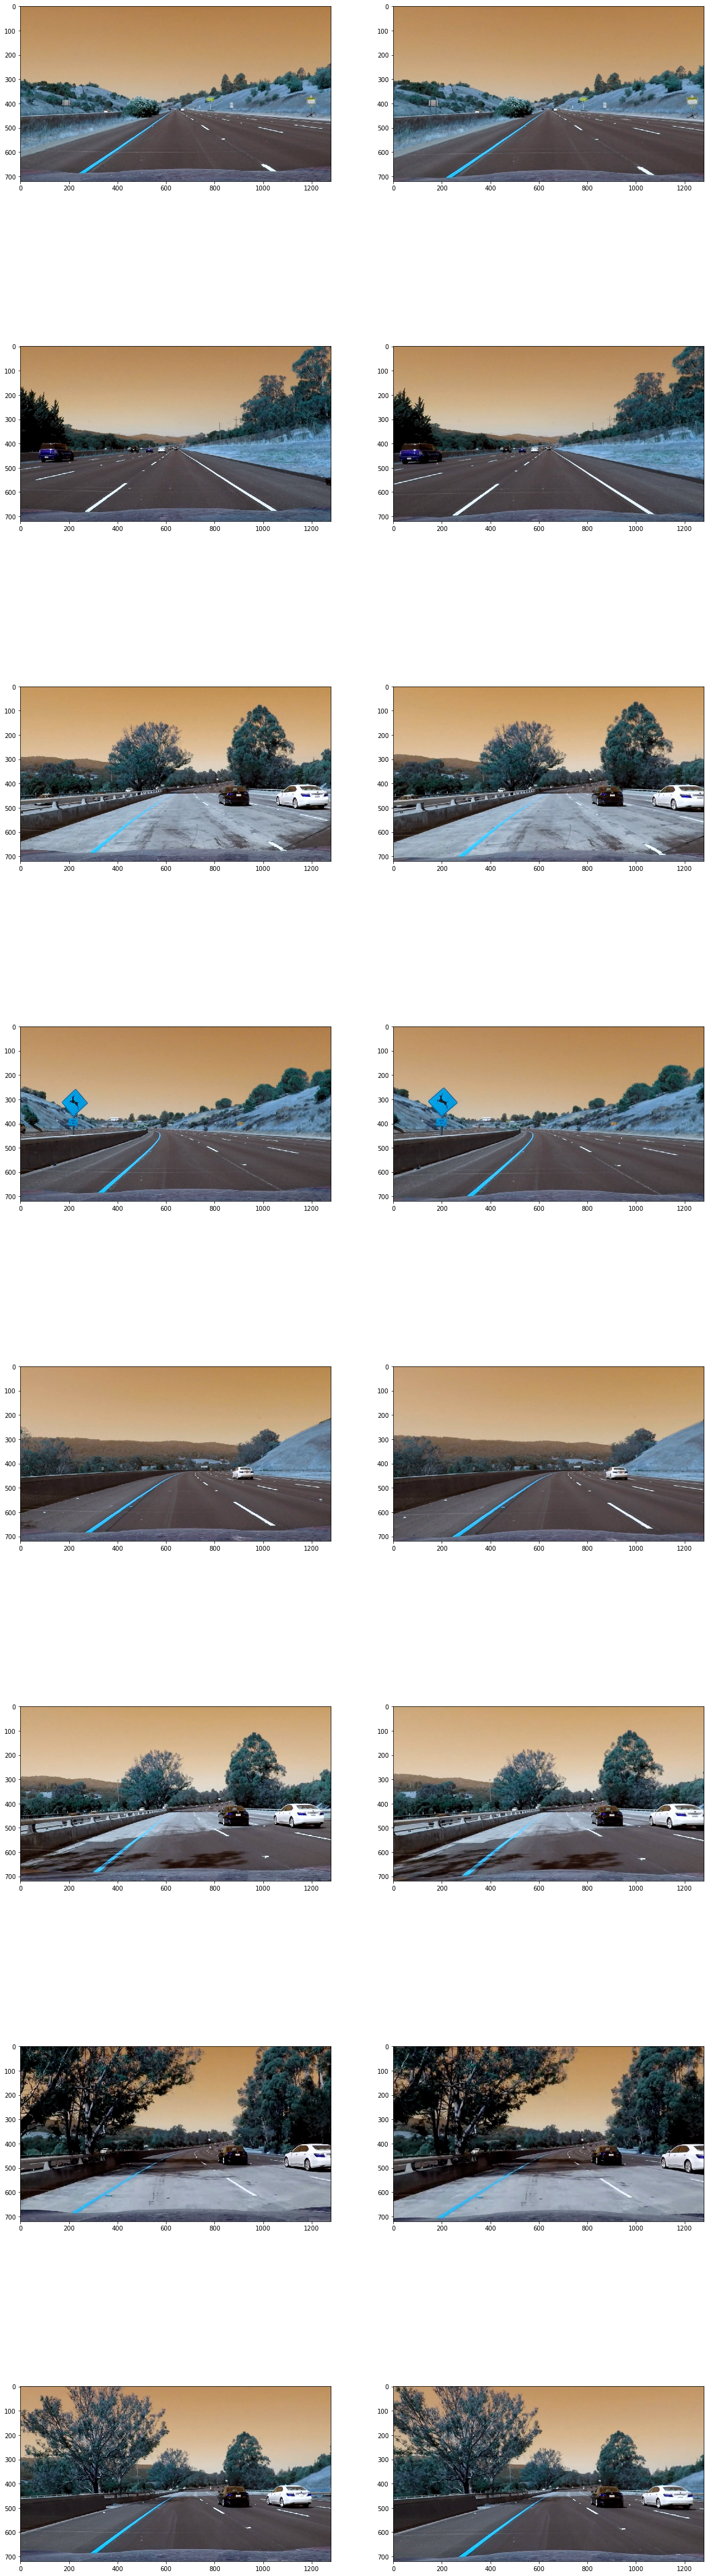

columns= 1  rows= 8  isGray= False


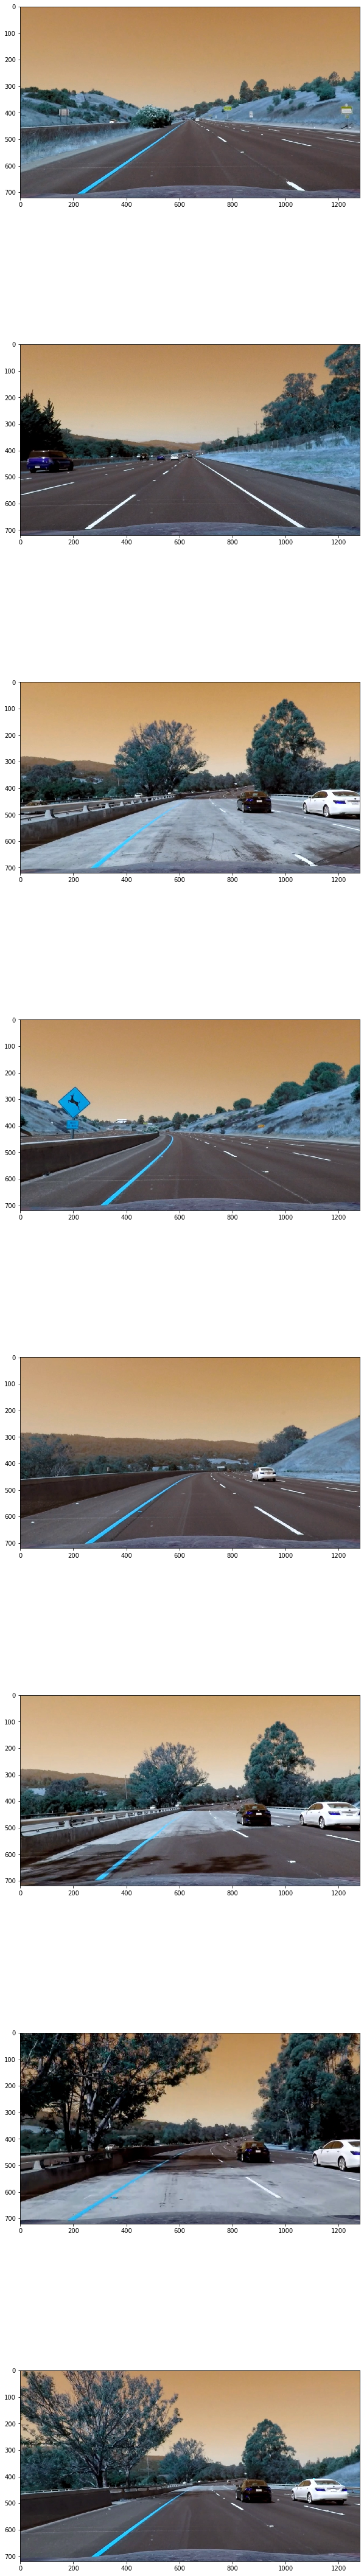

In [83]:
input_folder = 'test_images/'
output_folder = 'output_images/test_images/undistorted/'
input_file_pattern = '*.jpg'

# Make a list of test images
images = glob.glob(input_folder + input_file_pattern)
imagesForPrint = []
imgUndistorted = []
# print(images)
for idx, fname in enumerate(images):
    # print(fname)
    fileName = Path(fname).stem
    # print("fileName:", fileName)
    img = cv2.imread(fname)
    imagesForPrint.append(img)
    undist = undistortion(img, mtx, dist)
    imagesForPrint.append(undist)
    write_name = output_folder + 'undistorted_'+fileName+'.jpg'
    # print(write_name)
    imgUndistorted.append(undist)
    if not(cv2.imwrite(write_name, undist)):
        print("error by save", write_name)
    
showImages(imagesForPrint, 2,  rows = len(images))
showImages(imgUndistorted, 1, len(images))

#### transfrom 

In [66]:
# use the data from the write up desciption
# 585, 460 	320, 0
# 203, 720 	320, 720
# 1127, 720 	960, 720
# 695, 460 	960, 0
src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
dst = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])

src: [[ 585.  460.]
 [ 203.  720.]
 [1127.  720.]
 [ 695.  460.]]
dst [[320.   0.]
 [320. 720.]
 [960. 720.]
 [960.   0.]]
columns= 2  rows= 1  isGray= False


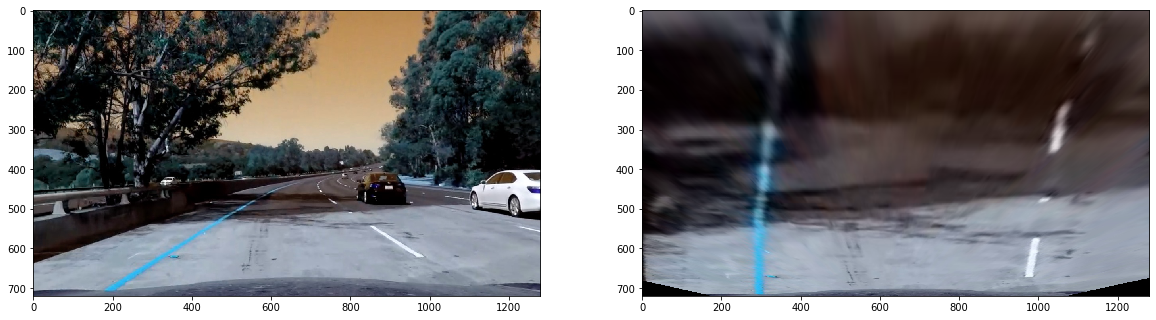

In [78]:
y1_org = 540
y2_org = 451
x1_org = 474
x2_org = 592
x3_org = 841
x4_org = 693

x1_2_persp = 530
y1_persp = 545
x3_4_persp = 730
y2_persp = 450

# src = np.float32([[x1_org, y1_org], [x2_org, y2_org], [x3_org, y1_org], [x4_org, y2_org]])
print("src:", src)

# dst = np.float32([[x1_2_persp, y1_persp], [x1_2_persp, y2_persp ], [x3_4_persp, y1_persp], [x3_4_persp, y2_persp]])
print("dst", dst)
M = cv2.getPerspectiveTransform(src, dst)


img = cv2.imread("output_images/test_images/disorted/undistorted_6.jpg")
warped = cv2.warpPerspective(img, M, img_size)
cv2.imwrite("output_images/test_images/disorted/warped_undistorted_6.jpg", warped)
images = [img, warped]
showImages(images,2)






Sobel Operatoru 

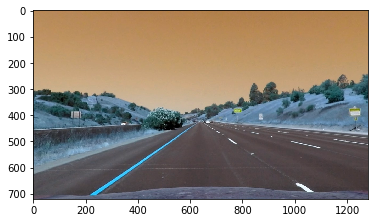

In [84]:
imgT = imgUndistorted[0]
plt.imshow(imgT)

Threshold gradient


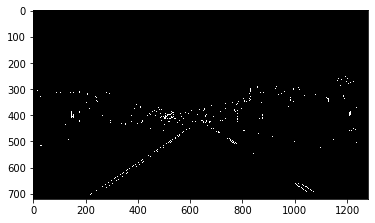

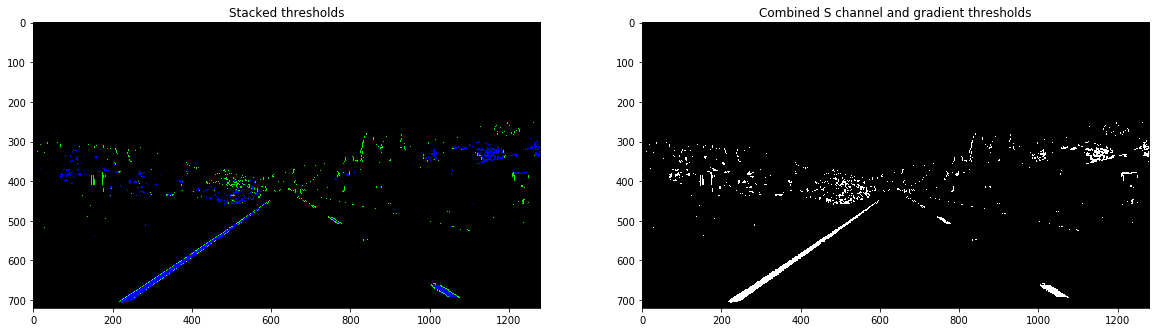

In [122]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(imgT, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(imgT, cv2.COLOR_RGB2GRAY)
# print("gray")
# plt.imshow(gray)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
# print("scaled_sobel")
# plt.imshow(scaled_sobel)


# Threshold x gradient
thresh_min = 60 # 20
thresh_max =  250# 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
print("Threshold gradient")
plt.imshow(sxbinary, cmap='gray')


# Threshold color channel
s_thresh_min =  130#170
s_thresh_max =  255# 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
# print("Threshold color channel")
# plt.imshow(s_binary)


# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
# print("color_binary")
# plt.imshow(color_binary)


# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')



columns= 3  rows= 8.0  isGray= True


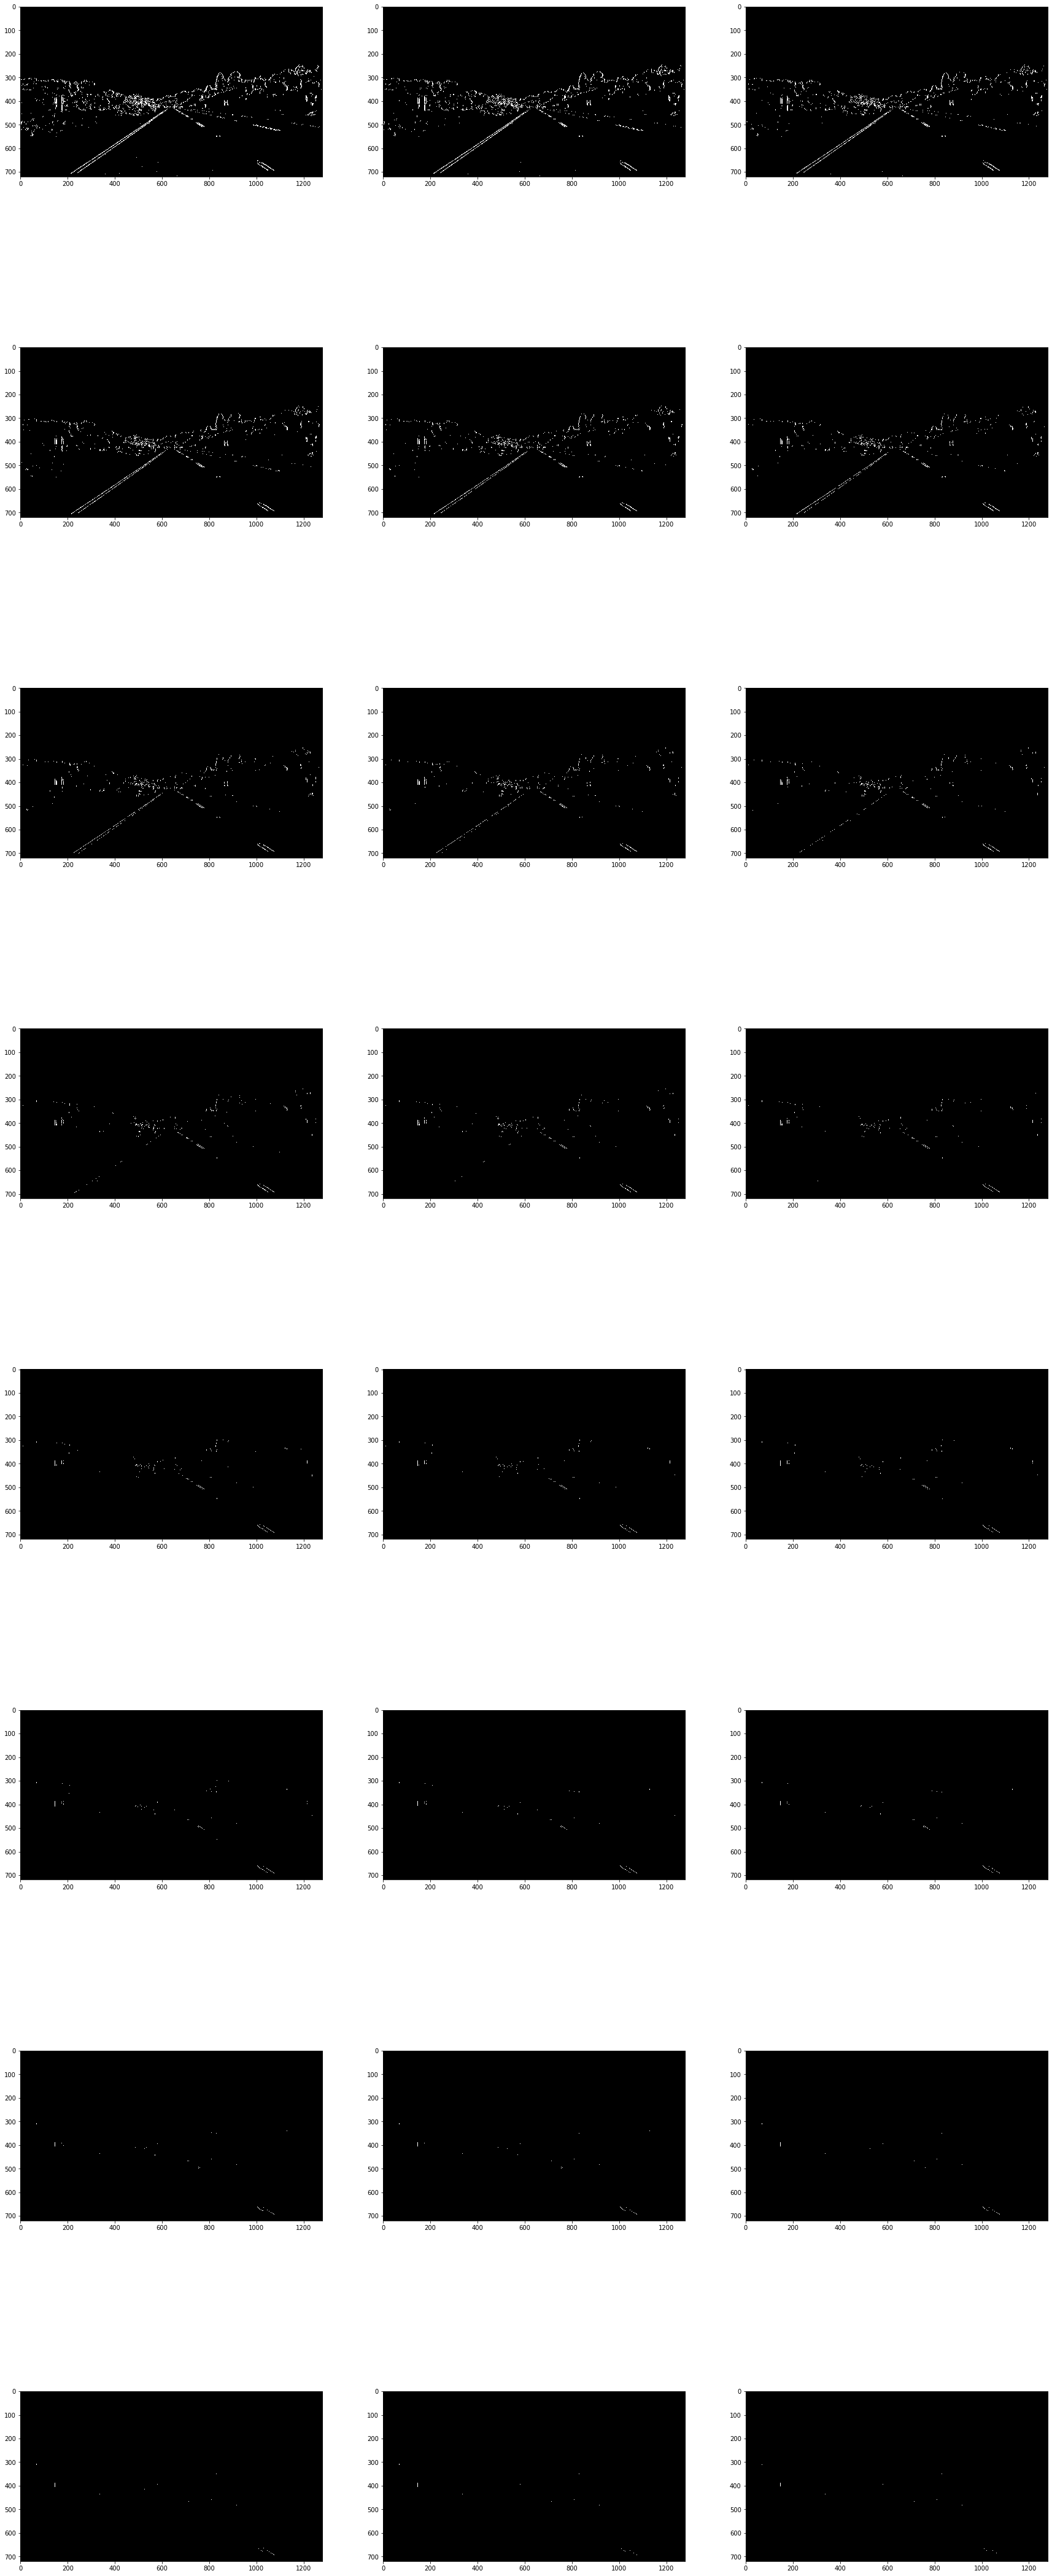

In [113]:
# Threshold x gradient
# thresh_min = 55 # 20
thresh_max =  250# 100
sxImg = []
for thresh_min in range(30,150,5):
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    sxImg.append(sxbinary)
    
showImages(sxImg, 3, len(sxImg)/3, isGray = True)
    

s_channel


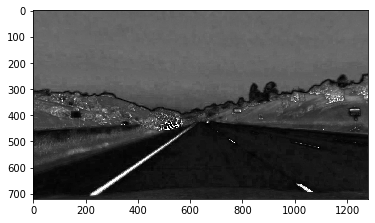

In [121]:

print("s_channel")
plt.imshow(s_channel, cmap='gray')

gray


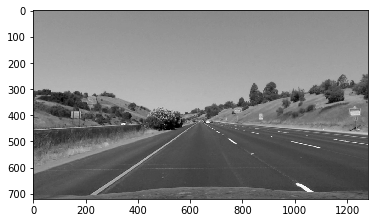

In [95]:
print("gray")
plt.imshow(gray, cmap='gray')

scaled_sobel


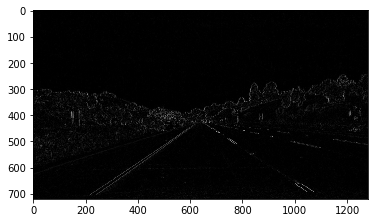

In [99]:
print("scaled_sobel")
plt.imshow(scaled_sobel,cmap='gray')


Threshold color channel


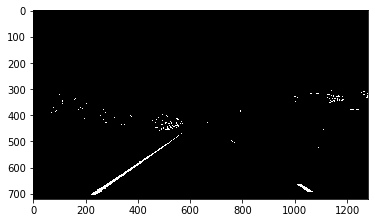

In [96]:
print("Threshold color channel")
plt.imshow(s_binary,cmap='gray')

color_binary


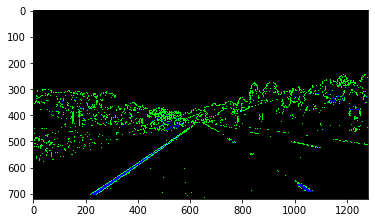

In [97]:
print("color_binary")
plt.imshow(color_binary,cmap='gray')